# Classification technique on the Breast Cancer dataset

## Setup

In [2]:
%matplotlib inline
# import necessary libraries and specify that graphs should be plotted inline. 
from sklearn.datasets import load_breast_cancer
from sklearn import tree,linear_model,neighbors, datasets
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, KFold
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report, roc_curve, auc
from sklearn.utils.multiclass import unique_labels
from sklearn.exceptions import ConvergenceWarning
from sklearn.svm import SVC
from sklearn.preprocessing import label_binarize, StandardScaler
from sklearn.ens import RandomForestClassifier
import scikitplot as skplt
import matplotlib.pyplot as plt
import numpy as np

In [3]:
# Ignoring warnings for clean output
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

## Loading and Exploring the data

In [4]:
# load the data set
bc = load_breast_cancer()
print(bc.DESCR)

.. _breast_cancer_dataset:

Breast cancer wisconsin (diagnostic) dataset
--------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 569

    :Number of Attributes: 30 numeric, predictive attributes and the class

    :Attribute Information:
        - radius (mean of distances from center to points on the perimeter)
        - texture (standard deviation of gray-scale values)
        - perimeter
        - area
        - smoothness (local variation in radius lengths)
        - compactness (perimeter^2 / area - 1.0)
        - concavity (severity of concave portions of the contour)
        - concave points (number of concave portions of the contour)
        - symmetry 
        - fractal dimension ("coastline approximation" - 1)

        The mean, standard error, and "worst" or largest (mean of the three
        largest values) of these features were computed for each image,
        resulting in 30 features.  For instance, field 3 is Mean Radius, f

In [5]:
## Explore the data set
n_samples, n_features = bc.data.shape
print(bc.keys())
print ('The dimensions of the data set are ', n_samples, 'by', n_features)
print()
print(bc.data.shape)
print(bc.target.shape)
print()
print('The classes are: \n', bc.target_names)
print()
print('The features in the data set are:\n', bc.feature_names)

dict_keys(['data', 'target', 'target_names', 'DESCR', 'feature_names', 'filename'])
The dimensions of the data set are  569 by 30

(569, 30)
(569,)

The classes are: 
 ['malignant' 'benign']

The features in the data set are:
 ['mean radius' 'mean texture' 'mean perimeter' 'mean area'
 'mean smoothness' 'mean compactness' 'mean concavity'
 'mean concave points' 'mean symmetry' 'mean fractal dimension'
 'radius error' 'texture error' 'perimeter error' 'area error'
 'smoothness error' 'compactness error' 'concavity error'
 'concave points error' 'symmetry error' 'fractal dimension error'
 'worst radius' 'worst texture' 'worst perimeter' 'worst area'
 'worst smoothness' 'worst compactness' 'worst concavity'
 'worst concave points' 'worst symmetry' 'worst fractal dimension']


## 1.Decision Trees 

### Modeling

Initialized the classifier with hyper-parameter **max_depth = 3** as the starting point as the Wisconsin Diagnostic Breast Cancer names file mentions that the best accuracy was received using 3 parameters - Worst Area, Worst Smoothness and Mean Texture

In [6]:
# We start with initializing our classifier.
clf = tree.DecisionTreeClassifier(max_depth = 3, random_state=45)

In [7]:
## Train the model (fit the data)
X_train, X_test, y_train, y_test = train_test_split(bc.data, bc.target, test_size=0.33,random_state=45)
clf = clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print("Accuracy: {0:.2%}".format(accuracy_score(y_test, y_pred)))
print()
#plot_confusion_matrix(y_test, y_pred, classes=bc.target_names,title='Confusion matrix')
print("Confusion Matrix: - \n",confusion_matrix(y_test, y_pred))
print()
print("Classification Report: - \n",classification_report(y_test, y_pred))

Accuracy: 94.15%

Confusion Matrix: - 
 [[ 60   8]
 [  3 117]]

Classification Report: - 
               precision    recall  f1-score   support

           0       0.95      0.88      0.92        68
           1       0.94      0.97      0.96       120

   micro avg       0.94      0.94      0.94       188
   macro avg       0.94      0.93      0.94       188
weighted avg       0.94      0.94      0.94       188



In [8]:
# After being fitted, the model can then be used to predict the class of samples:
print('The 1st instance is predicted to belong to class:', clf.predict(bc.data[:1, :]))
# Here we predict the class of a single value

# Alternatively, the probability of each class can be predicted, which is the fraction of training samples of the same class in a leaf:
print('The probabilities of belonging to each one of the classes are estimated as:', clf.predict_proba(bc.data[:1, :]))
# Here you can see the probability of each one of the classes

The 1st instance is predicted to belong to class: [0]
The probabilities of belonging to each one of the classes are estimated as: [[1. 0.]]


Hyper-parameter max_depth = 3 gives us a Accuracy of 94.15%.

Accuracy can be deceiving as it doesn't take into account false negatives. Being a medical case, breast cancer classification should minimize false negatives as this can lead lead to a persons death.

I am selecting F1-score for selecting the best estimator because it is a better measure than accuracy as this score takes both false positives and false negatives into account.

We get a weighted f1 score of 94% using this model which is a good starting point. Lets see if this can be improved by tuning the hyper parameters.

### Tuning the hyper-parameters

Now we see what is the best max-depth for maximizing accuracy in the test data. 

The **max-depth** of a tree defines the number of features used to classify the data. Using very few features would result in underfitting and using a lot of features would lead to over-fitting.

We also look at both criterions **gini** and **entropy** to see which gives us a better accuracy

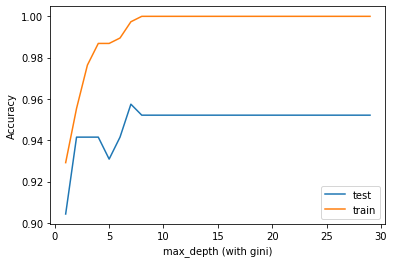

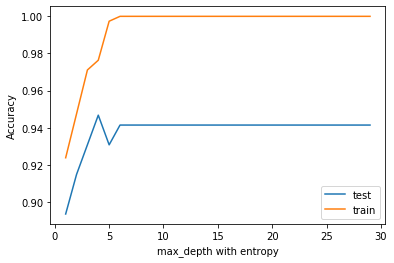

In [9]:
# Optimize decision tree and detect (potential) over-fitting
complexity_values = range(1,30)

X_train, X_test, y_train, y_test = train_test_split(bc.data, bc.target, test_size=0.33, random_state=45)

train_accuracies = []
test_accuracies=[]

for complexity_value in complexity_values:
    clf = tree.DecisionTreeClassifier(criterion="gini", max_depth=complexity_value, random_state=45)
    test_accuracies.append(clf.fit(X_train, y_train).score(X_test, y_test))
    train_accuracies.append(clf.fit(X_train, y_train).score(X_train, y_train))
    
# We want to plot our results
line1, =plt.plot(complexity_values, test_accuracies,label='test_accuracies')
line2, =plt.plot(complexity_values, train_accuracies,label='train_accuracies')
plt.xlabel("max_depth (with gini)")
plt.ylabel("Accuracy")
plt.legend((line1, line2), ('test', 'train'))
plt.show()

train_accuracies = []
test_accuracies=[]

for complexity_value in complexity_values:
    clf = tree.DecisionTreeClassifier(criterion="entropy", max_depth=complexity_value, random_state=45)
    test_accuracies.append(clf.fit(X_train, y_train).score(X_test, y_test))
    train_accuracies.append(clf.fit(X_train, y_train).score(X_train, y_train))
    
# We want to plot our results
line1, =plt.plot(complexity_values, test_accuracies,label='test_accuracies')
line2, =plt.plot(complexity_values, train_accuracies,label='train_accuracies')
plt.xlabel("max_depth with entropy")
plt.ylabel("Accuracy")
plt.legend((line1, line2), ('test', 'train'))
plt.show()

We plot a graph of train and test accuracy w.r.t max_depth and we can see that accuracy for the test data is maximum and close to the training data at **max_depth = 8 & criterion = "gini"**

**Underfitting** : If we use max_depth = 1, this would be under-fitting as we are using only one parameter to classify the the data. As seen in the above graph, our test and train accuracies are pretty low when max_depth is lower (1/2)

**Overfitting** : If our max_depth is large i.e greater than 6, we see 100% accuracy in the training data but the accuracy for test data is fluctuating. This is a case of over-fitting so we definitely want the max deph to be less than 6, and max_depth = 4 satisfies this condition.

### Tuning parameters - Nested CV & Grid search

To search for the best parameters, we run a nested cross-validation grid search with the following hyper parameters

1. criterion : to find an optimal criterion to calculate impurity of a node
2. max_depth : to search for the optimal number of features used for classification. Setting the right value for the max_depth (i.e. the number of features used for classification) is crucial to avoid overfitting or underfitting
3. min_samples_leaf : to search for the optimal minimum number of samples required to form a leaf
4. min_impurity_decrease : to search for the optimal minimum impurity decrease to split a node. If this split induces a decrease of the impurity greater than or equal to min_impurity_decrease only then the split will happen. This prevents splits where information gain is very low.

Being a medical case, breast cancer classification should **minimize false negatives** as this can lead lead to a persons death.

I am selecting **F1-score** for selecting the best estimator because it is a better measure than accuracy as this score takes both false positives and false negatives into account. 

In [10]:
X_train,X_test,y_train,y_test = train_test_split(bc.data, bc.target,test_size=0.33,random_state=45)

param_grid = dict(criterion = ["gini", "entropy"], 
                  max_depth = range(2,10),
                  min_samples_leaf = range(2,8),
                  min_impurity_decrease = [0,1e-8,1e-7,1e-6,1e-5,1e-4]
                 )

grid_tree_clf = tree.DecisionTreeClassifier(random_state=45)

inner_cv = KFold(n_splits=4, shuffle=True, random_state=45)
outer_cv = KFold(n_splits=4, shuffle=True, random_state=45)

grid_tree = GridSearchCV(grid_tree_clf, param_grid, cv = inner_cv, scoring='f1',n_jobs=-1)
grid_tree.fit(X_train,y_train)

# Nested CV with parameter optimization
nested_score = cross_val_score(grid_tree, bc.data, bc.target, cv=outer_cv)

In [11]:
print("Using Nested CV with grid search, we acheive accuracy: {0:.2%} +/- {1:.2%}".format(nested_score.mean(), nested_score.std()))
print()
print ("The best hyper-parameters to get these accuracy are :-\n", grid_tree.best_params_)
print()
print ("The best decision tree classifier is :-\n", grid_tree.best_estimator_)
y_pred = grid_tree.best_estimator_.predict(X_test)
#plot_confusion_matrix(y_test, y_pred, classes=bc.target_names,title='Confusion matrix')
print("Confusion Matrix: - \n",confusion_matrix(y_test, y_pred))
print()
print("Classification Report: - \n",classification_report(y_test, y_pred))

Using Nested CV with grid search, we acheive accuracy: 94.12% +/- 0.70%

The best hyper-parameters to get these accuracy are :-
 {'criterion': 'gini', 'max_depth': 4, 'min_impurity_decrease': 0, 'min_samples_leaf': 5}

The best decision tree classifier is :-
 DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=4,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=45,
            splitter='best')
Confusion Matrix: - 
 [[ 62   6]
 [  1 119]]

Classification Report: - 
               precision    recall  f1-score   support

           0       0.98      0.91      0.95        68
           1       0.95      0.99      0.97       120

   micro avg       0.96      0.96      0.96       188
   macro avg       0.97      0.95      0.96       188
weighted avg       0.96      0.96      0.96       18

### Results - Model Goodness

**Model Goodness**
The class distribution is 357 benign, 212 malignant, which would get us an accuracy of 357/(357+212) = 62.74% by majority rule, so an **Accuracy of 94.12% +/- 0.70%** by decision tree classification is a good model.

Our model was chosen based of **f1-score which is 96%** which is the harmonic mean of precision and recall and hecne a good measure to determine a good fit.

False Negatives can be a problem since it is a medical case and we would like to minimize the number of **false negatives which is 6** in this case.

Therefore, the following Hyperparameters,  'criterion': 'gini', 'max_depth': 4, 'min_impurity_decrease': 0, 'min_samples_leaf': 5 help us increase the accuracy to 94.12% +/- 1.41%, while maintaining the same f1 score of 96%.

### ROC and Lift Curves

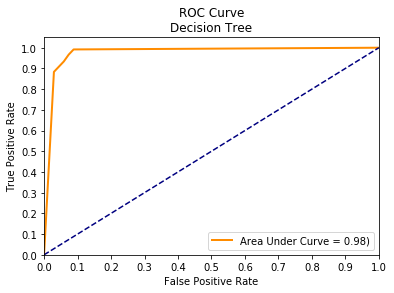

In [12]:
y_score = grid_tree.best_estimator_.predict_proba(X_test)

fpr, tpr, _ = roc_curve(y_test, y_score[:,1])
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange',
         lw=2, label='Area Under Curve = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xticks(np.arange(0,1.1,0.1))
plt.yticks(np.arange(0,1.1,0.1))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve\nDecision Tree')
plt.legend(loc="lower right")
plt.show()

For this use case, it is crucial to have the cancerour cells classified correctly. Therefore having a **high sensitivity i.e. true positive rate (by minimizing false negatives)** is more important than decreasing **specificity i.e. false positive rate.** It is okay to have some false positives as they would be identified as non-cancerous in later stages of diagnosis. Therefore, we should choose a threshold which maximizes false positive rate.

In [13]:
#Ranked list of probabilities
np.sort(y_score[:,1])[::-1]

array([0.99509804, 0.99509804, 0.99509804, 0.99509804, 0.99509804,
       0.99509804, 0.99509804, 0.99509804, 0.99509804, 0.99509804,
       0.99509804, 0.99509804, 0.99509804, 0.99509804, 0.99509804,
       0.99509804, 0.99509804, 0.99509804, 0.99509804, 0.99509804,
       0.99509804, 0.99509804, 0.99509804, 0.99509804, 0.99509804,
       0.99509804, 0.99509804, 0.99509804, 0.99509804, 0.99509804,
       0.99509804, 0.99509804, 0.99509804, 0.99509804, 0.99509804,
       0.99509804, 0.99509804, 0.99509804, 0.99509804, 0.99509804,
       0.99509804, 0.99509804, 0.99509804, 0.99509804, 0.99509804,
       0.99509804, 0.99509804, 0.99509804, 0.99509804, 0.99509804,
       0.99509804, 0.99509804, 0.99509804, 0.99509804, 0.99509804,
       0.99509804, 0.99509804, 0.99509804, 0.99509804, 0.99509804,
       0.99509804, 0.99509804, 0.99509804, 0.99509804, 0.99509804,
       0.99509804, 0.99509804, 0.99509804, 0.99509804, 0.99509804,
       0.99509804, 0.99509804, 0.99509804, 0.99509804, 0.99509

**Area under ROC Curve**

The area under the ROC curve is 0.98 which means that within the above ranking list, if we randomly choose a cell that is malignant and randomly choose a cell that is benign, theer is a 98% probability that the cell that is malignant will be ranked higher than the cell that is begin. This is a very high valu for AUC.

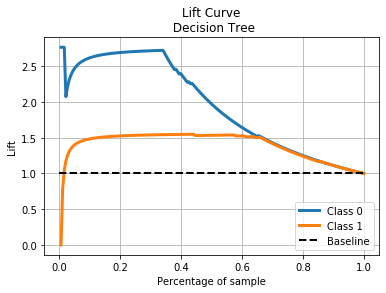

In [14]:
# Plot the lift curve
skplt.metrics.plot_lift_curve(y_test, y_score, title = "Lift Curve\n Decision Tree")
plt.show()

The lift curve tells us that as compared to random guess, our decision tree classifier classifies mallignant cells 1.5x better.

## 2.K-Nearest Neighbours

### Modeling

We start by looking at the test data and training data accuracies for number of neighbours from 1 to 30. We have scaled the data to normalise it for better classification results by avoiding missclasification due to the magnitude of the features

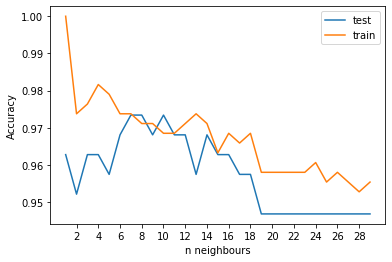

In [15]:
n_neighbors = range(1,30)

# KNeighborsClassifier is implementing the k-nearest neighbors vote
X_train, X_test, y_train, y_test = train_test_split(bc.data, bc.target, test_size=0.33, random_state = 45)

# normalization of data for KNN
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

train_accuracies = []
test_accuracies=[]

for n in n_neighbors:
    clf = neighbors.KNeighborsClassifier(n)
    test_accuracies.append(clf.fit(X_train, y_train).score(X_test, y_test))
    train_accuracies.append(clf.fit(X_train, y_train).score(X_train, y_train))    

# We want to plot our results
line1, =plt.plot(n_neighbors, test_accuracies,label='test_accuracies')
line2, =plt.plot(n_neighbors, train_accuracies,label='train_accuracies')
plt.xlabel("n neighbours")
plt.ylabel("Accuracy")
plt.xticks(range(2,30,2))
plt.legend((line1, line2), ('test', 'train'))
plt.show()

We see that the test and train data accuracies converge at **n = 8 neighbours**. So we use 6 nearest neighbours as a starting point for our K Nearest Neighbours classifier

**Overfitting** : If the classification is done based on very few neighbours (1 or 2), we see that the training data accuracy is very high but test data accuracy is very low. This indicates over-fitting as items are classified based on very few neighbours and classifcation may be done based on few outliers resulting in no definite boundaries for classification.

**Underfitting** : Using a high number of neighbours to classify can lead to underfitting. An extreme case of this would be where all the samples are looked at for fitting which would lead to a naive (majority) rule classification.

### Tuning parameters - Nested CV & Grid search

To search for the best parameters, we run a grid search with the following hyper parameters

1. weights : To check whether assigneing **uniform weights or weights based on distance** give a us better model. 
2. n_neighbors : As defined earlier, it is crucial to select an optimal number of neighbours to run the classification model.

In [16]:
k_range = list(range(1,30))
weight_options = ["uniform", "distance"]
param_grid = dict(n_neighbors = k_range, weights = weight_options)

grid_knn_clf = neighbors.KNeighborsClassifier()

inner_cv = KFold(n_splits=4, shuffle=True, random_state=45)
outer_cv = KFold(n_splits=4, shuffle=True, random_state=45)

grid_knn = GridSearchCV(grid_knn_clf, param_grid, cv = inner_cv, scoring='f1',n_jobs=-1)
grid_knn.fit(X_train,y_train)

# Nested CV with parameter optimization
nested_score = cross_val_score(grid_knn, bc.data, bc.target, cv=outer_cv)

In [17]:
print("Using Nested CV with grid search, we acheive accuracy: {0:.2%} +/- {1:.2%}".format(nested_score.mean(), nested_score.std()))
print()
print ("The best hyper-parameters to get these accuracy are :-\n", grid_knn.best_params_)
print()
print ("The best KNN classifier is :-\n", grid_knn.best_estimator_)
y_pred = grid_knn.best_estimator_.predict(X_test)
#plot_confusion_matrix(y_test, y_pred, classes=bc.target_names,title='Confusion matrix')
print("Confusion Matrix: - \n",confusion_matrix(y_test, y_pred))
print()
print("Classification Report: - \n",classification_report(y_test, y_pred))

Using Nested CV with grid search, we acheive accuracy: 94.35% +/- 0.78%

The best hyper-parameters to get these accuracy are :-
 {'n_neighbors': 8, 'weights': 'distance'}

The best KNN classifier is :-
 KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=8, p=2,
           weights='distance')
Confusion Matrix: - 
 [[ 63   5]
 [  1 119]]

Classification Report: - 
               precision    recall  f1-score   support

           0       0.98      0.93      0.95        68
           1       0.96      0.99      0.98       120

   micro avg       0.97      0.97      0.97       188
   macro avg       0.97      0.96      0.96       188
weighted avg       0.97      0.97      0.97       188



### Results - Model Goodness

**Model Goodness**
The class distribution is 357 benign, 212 malignant, which would get us an accuracy of 357/(357+212) = 62.74% by majority rule, so an **Accuracy of 94.35% +/- 0.78%** by k nearest neighbours is a good model. The accuracy is slightly higher than the one received by our best Decision Tree Classifier (94.12%) but the standard deviation also increases slightly from the Decision Tree (0.7%), so we cna deem both models as equally good based on accuracy.

However, we see that **f1-score which is 97%** in this model with hyper parameters set as n = 8 neighbours and weighted distances which is the harmonic mean of precision and recall and is higher compared to decision trees. So this model is better so far

False Negatives can be a problem since it is a medical case and we would like to minimize the number of **false negatives which is 5** in this case, which again is lower than Decision Tree Classifier.

So far, the accuracy is almost similar to the one acheived by the decision tree classifier, however KNN Classifier has a lower number of false negatives and higher f1-score.

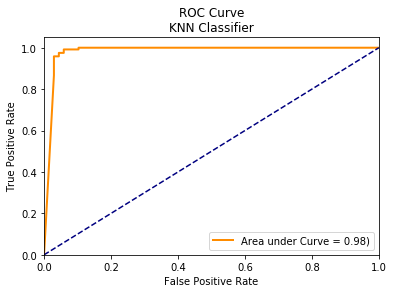

In [18]:
y_score = grid_knn.best_estimator_.predict_proba(X_test)

fpr, tpr, _ = roc_curve(y_test, y_score[:,1])
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange',
         lw=2, label='Area under Curve = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve\nKNN Classifier')
plt.legend(loc="lower right")
plt.show()

For this use case, it is crucial to have the cancerour cells classified correctly. Therefore having a **high sensitivity i.e. true positive rate (by minimizing false negatives)** is more important than decreasing **specificity i.e. false positive rate.** It is okay to have some false positives as they would be identified as non-cancerous in later stages of diagnosis. Therefore, we should choose a threshold which maximizes false positive rate.

In [19]:
#Ranked list of probabilities
np.sort(y_score[:,1])[::-1]

array([1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.     

**Area under ROC Curve**

The area under the ROC curve is 0.98 which means that within the above ranking list, if we randomly choose a cell that is malignant and randomly choose a cell that is benign, theer is a 98% probability that the cell that is malignant will be ranked higher than the cell that is begin. This is a very high value for AUC.

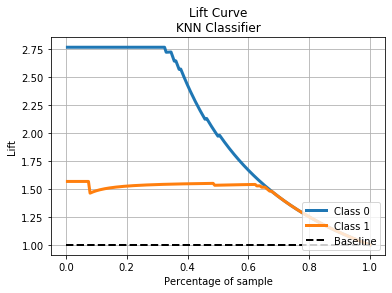

In [20]:
# Plot the lift curve
skplt.metrics.plot_lift_curve(y_test, y_score, title = 'Lift Curve\nKNN Classifier')
plt.show()

The lift curve tells us that as compared to random guess, our knn classifier classifies mallignant cells 1.5x better at 0.5 as the threshold which is chosen by default. We can also chose a threshold close to 0.6

## 3.Logistic regression

### Modeling

As a starting point, we run the Logistic regression classifer with an L1 penalty as a hyper parameter. This is used of regularization of the co-efficients. L1 is useful as it can push feature coefficients to 0, creating a method for feature selection.

In [21]:
clf = linear_model.LogisticRegression(penalty='l1', random_state=45)
clf.fit(X_train, y_train)
scores = cross_val_score(clf, bc.data, bc.target, cv=5)
print("Accuracy: {0:.2%} +/- {1:.2%}".format(scores.mean(), scores.std()))
print('The 1st instance is predicted to belong to class:', clf.predict(bc.data[:1, :]))
print('The probabilities of belonging to each one of the classes are estimated as:', clf.predict_proba(bc.data[:1, :]))

Accuracy: 95.09% +/- 1.59%
The 1st instance is predicted to belong to class: [0]
The probabilities of belonging to each one of the classes are estimated as: [[1. 0.]]


In [22]:
y_pred = clf.predict(X_test)
#plot_confusion_matrix(y_test, y_pred, classes=bc.target_names,title='Confusion matrix')
print("Confusion Matrix: - \n",confusion_matrix(y_test, y_pred))
print()
print("Classification Report: - \n",classification_report(y_test, y_pred))

Confusion Matrix: - 
 [[ 65   3]
 [  0 120]]

Classification Report: - 
               precision    recall  f1-score   support

           0       1.00      0.96      0.98        68
           1       0.98      1.00      0.99       120

   micro avg       0.98      0.98      0.98       188
   macro avg       0.99      0.98      0.98       188
weighted avg       0.98      0.98      0.98       188



### Goodness of fit

Hyper-parameter **penalty='l1'** gives us a **95.09% +/- 1.59%** using a 5 fold cross-validation which is the best accuracy we have so far, but the standard deviation of 1.59% is very high.

The **false negative cases is reduced to 3** which is good fit compared to all models so far for the accuracy.

We also have a **high precision, recall and f-score.**

The f-score is 98% which is the highest among all models so far.

**Overfitting**
Logistic regression is a linear model and overfitting can occur when the model is very complex, i.e. having too many parameters relative to the number of observations. A model that has been overfit has poor predictive performance, as it overreacts to minor fluctuations in the training data.

To avoid overfitting, we use regularization. There are two typees of regularization, L1 and L2 and we check both of these as well as regularization strength using grid search.

### Tuning parameters - Nested CV & Grid search

To search for the best parameters, we run a nested cross validation with grid search with the following hyper parameters

1. penalty : To check whether l1 or l2 penalty gives us a better result. 
2. C : We also check what is an optimal value for regularization strength. The hyper-parameter 'C' is 1 / lambda (which is an inverse of the penalty or regularization strength.

In [23]:
grid_values = {'penalty': ['l1', 'l2'], \
               'C':[1e-4,0.001,.009,0.01,.09,1,5,10,25,100,1000,1e4]}

clf = linear_model.LogisticRegression(random_state=45)

inner_cv = KFold(n_splits=4, shuffle=True, random_state=45)
outer_cv = KFold(n_splits=4, shuffle=True, random_state=45)

grid_logit = GridSearchCV(clf, grid_values, cv = inner_cv, scoring='f1',n_jobs=-1)
grid_logit.fit(X_train,y_train)

# Nested CV with parameter optimization
nested_score = cross_val_score(grid_logit, bc.data, bc.target, cv=outer_cv)

In [24]:
print("Using Nested CV with grid search, we acheive accuracy: {0:.2%} +/- {1:.2%}".format(nested_score.mean(), nested_score.std()))
print()
print ("The best hyper-parameters to get these accuracy are :-\n", grid_logit.best_params_)
print()
print ("The best logistic regression classifier is :-\n", grid_logit.best_estimator_)
y_pred = grid_logit.best_estimator_.predict(X_test)
#plot_confusion_matrix(y_test, y_pred, classes=bc.target_names,title='Confusion matrix')
print("Confusion Matrix: - \n",confusion_matrix(y_test, y_pred))
print()
print("Classification Report: - \n",classification_report(y_test, y_pred))

Using Nested CV with grid search, we acheive accuracy: 97.32% +/- 1.57%

The best hyper-parameters to get these accuracy are :-
 {'C': 0.09, 'penalty': 'l2'}

The best logistic regression classifier is :-
 LogisticRegression(C=0.09, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=45, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)
Confusion Matrix: - 
 [[ 65   3]
 [  0 120]]

Classification Report: - 
               precision    recall  f1-score   support

           0       1.00      0.96      0.98        68
           1       0.98      1.00      0.99       120

   micro avg       0.98      0.98      0.98       188
   macro avg       0.99      0.98      0.98       188
weighted avg       0.98      0.98      0.98       188



### Goodness of fit

Logistic regression grid search with nested cross validation tells us that the best parameters are **C: 0.09, penalty: 'l2'**

This gives us a high precision and recall of 97%, accuracy of 97.32% +/- 1.57% and a **very good f1-score of 97%** which is the highest so far.

To avoid overfitting, we use regularization by a L2 penalty and a C parameter value = .09. Using this, we get an accuracy of 97.32% +/- 1.57%. The only concern might be that the standard devition of 1.57% is higher than those received with Tree and KNN Nested CV so far.

Logistic regression also has the least number of false negatives compared to all classifiers so far that is 3.

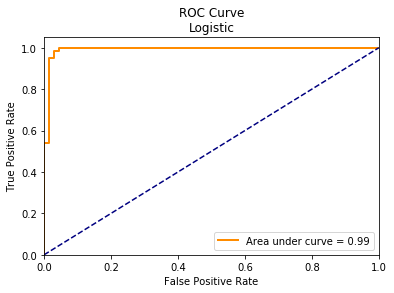

In [25]:
y_score = grid_logit.best_estimator_.predict_proba(X_test)

fpr, tpr, _ = roc_curve(y_test, y_score[:,1])
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange',
         lw=2, label='Area under curve = %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve\nLogistic')
plt.legend(loc="lower right")
plt.show()

For this use case, it is crucial to have the cancerour cells classified correctly. Therefore having a high sensitivity i.e. true positive rate (by minimizing false negatives) is more important than decreasing specificity i.e. false positive rate. It is okay to have some false positives as they would be identified as non-cancerous in later stages of diagnosis. Therefore, we should choose a threshold which maximizes false positive rate.

In [26]:
#Ranked list of probabilities
np.sort(y_score[:,1])[::-1]

array([9.99740252e-01, 9.99617427e-01, 9.99213029e-01, 9.98996313e-01,
       9.98973771e-01, 9.98816258e-01, 9.98802179e-01, 9.98775644e-01,
       9.98627456e-01, 9.98369907e-01, 9.98190980e-01, 9.97988514e-01,
       9.97930539e-01, 9.97870452e-01, 9.97870297e-01, 9.97827047e-01,
       9.97801118e-01, 9.97720776e-01, 9.97613453e-01, 9.97354441e-01,
       9.97320544e-01, 9.97305572e-01, 9.96857832e-01, 9.96693954e-01,
       9.96648556e-01, 9.96517444e-01, 9.96199773e-01, 9.95632724e-01,
       9.94862486e-01, 9.94820653e-01, 9.94610597e-01, 9.94366804e-01,
       9.94137252e-01, 9.93866075e-01, 9.93511052e-01, 9.93392563e-01,
       9.93344341e-01, 9.93252370e-01, 9.92669766e-01, 9.92320490e-01,
       9.91424387e-01, 9.91341051e-01, 9.90127017e-01, 9.90108780e-01,
       9.89730753e-01, 9.89075271e-01, 9.89005222e-01, 9.88986014e-01,
       9.88759553e-01, 9.88728672e-01, 9.88446346e-01, 9.88285845e-01,
       9.87745482e-01, 9.86997935e-01, 9.86641828e-01, 9.85666545e-01,
      

**Area under ROC Curve**

The area under the ROC curve is 0.99 which means that within the above ranking list, if we randomly choose a cell that is malignant and randomly choose a cell that is benign, theer is a 99% probability that the cell that is malignant will be ranked higher than the cell that is begin. This is a very high value for AUC, highest so far compared to other classifiers.

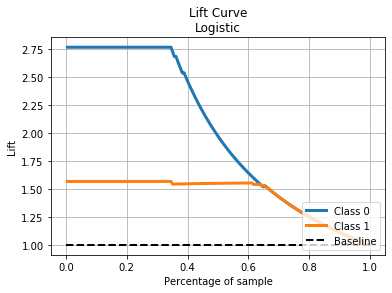

In [27]:
# Plot the lift curve
skplt.metrics.plot_lift_curve(y_test, y_score, title = 'Lift Curve\nLogistic')
plt.show()

The lift curve tells us that as compared to random guess, our knn classifier classifies mallignant cells about 1.55x better at 0.5 as the threshold which is chosen by default. We can also chose a threshold close to 0.6

## 4. SVM

In [28]:
model = SVC(kernel = 'linear', random_state = 45)

# feeding the training data into the model
model.fit(X_train, y_train)

# predicting the values for x-test
y_pred = model.predict(X_test)

# finding the training and testing accuracy
print("Training Accuracy: ",model.score(X_train, y_train))
print("Testing Accuracy: ", model.score(X_test, y_test))

print("Confusion Matrix: - \n",confusion_matrix(y_test, y_pred))
print()
print("Classification Report: - \n",classification_report(y_test, y_pred))

Training Accuracy:  0.989501312335958
Testing Accuracy:  0.9574468085106383
Confusion Matrix: - 
 [[ 61   7]
 [  1 119]]

Classification Report: - 
               precision    recall  f1-score   support

           0       0.98      0.90      0.94        68
           1       0.94      0.99      0.97       120

   micro avg       0.96      0.96      0.96       188
   macro avg       0.96      0.94      0.95       188
weighted avg       0.96      0.96      0.96       188



### Tuning parameters - Nested CV & Grid search

To search for the best parameters, we run a nested cross validation with grid search with the following hyper parameters

1. C: This heps us introduce soft margin to the SVM classification, allowing for outliers. Larger the C, smaller number of errors are allowed. It is a way of controlling overfitting - by making C smaller, we allow some outliers

2. gamma: For the gaussian rbf kernel trick, we cna specify the number of neighbours that the svm classifier will look at for deciding the boundaires. A large gamma value indicates looking at few neighbours and cna lead to overfitting the model. A small gamma value leads to looking at a large number of neighbours.

3. kernel trick: for data points that are linearly seperable, we can use the linear kernel and rbf kernel is for guassian distribution. We add these to the gridsearch to see which is better for our classification problem.

In [29]:
Cs = [0.01, 0.1, 1, 10, 100]
gammas = [0.001, 0.01, 0.1, 1]
kernels = ['linear','rbf']
param_grid = {'kernel':kernels,'C': Cs, 'gamma' : gammas}

model = SVC(probability=True,random_state = 45)

inner_cv = KFold(n_splits=4, shuffle=True, random_state=45)
outer_cv = KFold(n_splits=4, shuffle=True, random_state=45)

grid_svm = GridSearchCV(model, param_grid, cv = inner_cv, scoring='f1',n_jobs=-1)
grid_svm.fit(X_train,y_train)

# Nested CV with parameter optimization
nested_score = cross_val_score(grid_svm, bc.data, bc.target, cv=outer_cv)

In [30]:
print("Using Nested CV with grid search, we acheive accuracy: {0:.2%} +/- {1:.2%}".format(nested_score.mean(), nested_score.std()))
print()
print ("The best hyper-parameters to get these accuracy are :-\n", grid_svm.best_params_)
print()
print ("The best SVM classifier is :-\n", grid_svm.best_estimator_)
y_pred = grid_svm.best_estimator_.predict(X_test)
#plot_confusion_matrix(y_test, y_pred, classes=bc.target_names,title='Confusion matrix')
print("Confusion Matrix: - \n",confusion_matrix(y_test, y_pred))
print()
print("Classification Report: - \n",classification_report(y_test, y_pred))

Using Nested CV with grid search, we acheive accuracy: 95.79% +/- 1.32%

The best hyper-parameters to get these accuracy are :-
 {'C': 1, 'gamma': 0.001, 'kernel': 'linear'}

The best SVM classifier is :-
 SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.001, kernel='linear',
  max_iter=-1, probability=True, random_state=45, shrinking=True,
  tol=0.001, verbose=False)
Confusion Matrix: - 
 [[ 61   7]
 [  1 119]]

Classification Report: - 
               precision    recall  f1-score   support

           0       0.98      0.90      0.94        68
           1       0.94      0.99      0.97       120

   micro avg       0.96      0.96      0.96       188
   macro avg       0.96      0.94      0.95       188
weighted avg       0.96      0.96      0.96       188



### Goodness of fit

SVM grid search with nested cross validation tells us that the best parameters are **Kernel: Linear, C: 1, gamma: 0.001**

This gives us a high precision and recall of 96%, accuracy of 95.79% +/- 1.32% and a **good f1-score of 96%**. This is lower than the accuracy and f1-score received with Logistic regression, but the standard deviation in accuracy is lower in SVM which is good.

However, we have a high number of false negatives (7) which is not good for our use case

In [ ]:
# Since probability hyper parameter is set to true, 
# svc overlays logistic regression over the svm classification to prodict probability
y_score = grid_svm.best_estimator_.predict_proba(X_test)

fpr, tpr, _ = roc_curve(y_test, y_score[:,1])
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange',
         lw=2, label='Area under Curve = %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve\nSVM')
plt.legend(loc="lower right")
plt.show()

For this use case, it is crucial to have the cancerour cells classified correctly. Therefore having a high sensitivity i.e. true positive rate (by minimizing false negatives) is more important than decreasing specificity i.e. false positive rate. It is okay to have some false positives as they would be identified as non-cancerous in later stages of diagnosis. Therefore, we should choose a threshold which maximizes false positive rate.

In [ ]:
#Ranked list of probabilities
np.sort(y_score[:,1])[::-1]

**Area under ROC Curve**

The area under the ROC curve is 0.99 which means that within the above ranking list, if we randomly choose a cell that is malignant and randomly choose a cell that is benign, theer is a 99% probability that the cell that is malignant will be ranked higher than the cell that is begin. This is a very high value for AUC, highest so far compared to other classifiers.

In [ ]:
# Plot the lift curve
skplt.metrics.plot_lift_curve(y_test, y_score, title = 'Lift Curve\nSVM')
plt.show()

The lift curve tells us that as compared to random guess, our knn classifier classifies mallignant cells about 1.55x better at 0.5 as the threshold which is chosen by default. We can also chose a threshold close to 0.6

## Model Selection

**Comparing all the models that have been analyzed so far:-**

| Model                   |   Best Parameters <br />(Using NestedCV with GridSearchCV)   |             Accuracy | F1 Score | Number of False Negatives | Area Under ROC Curve |
| :---------------------- | :----------------------------------------------------------: | -------------------: | -------: | ------------------------: | -------------------: |
| Decision Tree           | criterion: gini<br />max_depth: 4<br />min_impurity_decrease: 0<br /> min_samples_leaf: 5 |     94.12% +/- 0.70% |      96% |                         6 |                 0.98 |
| K Nearest Neighbours    |            n_neighbors: 8<br /> weights: distance            |     94.35% +/- 0.78% |      97% |                         5 |                 0.98 |
| **Logistic Regression** |                   C: 0.09<br />penalty: l2                   | **97.32% +/- 1.57%** |  **98%** |                     **3** |             **0.99** |
| SVM                     |                   kernel: linear <br />C: 1<br /> gamma: 0.001                    |     95.79% +/- 1.32% |  96% |                         7 |                 **0.99** |

As we can see from the above table, **Logistic Regression** gives us the highest F1-Score of 98% with a high accuracy of 97.32% +/- 1.57%. Even though the standard deviation is higher in logistic regression, we choose this for classification due to the high F1-Score, low number of false negatives and highest area under the ROC curve.

Being a medical case, **False Negatives** can be a big problem as it is a matter of life and death.  **Logistic Regression** with C: 0.09 penalty: l2 hyper parameters, also acheives a minimum number of false negatives (of 3) as seen in the confusion matrix. For these results, we use regularization by a L2 penalty and a C parameter value = 0.09.

The area under the ROC curve is high for all the classifiers. In our case, since we want to minimize false negatives, the true positive rate should be high and a large area under the ROC curve is good for this. We get an area of 0.99 for both Logistic and SVM indicating that if we randomly choose a cell that is malignant and randomly choose a cell that is benign, theer is a 99% probability that the cell that is malignant will be ranked higher than the cell that is begin.

Based on the above analyses, we can conculde that among the 4 models discussed, **Logistic regression** gives us the best fit for classifying breast cancer cells and **malignant or benign**.